In [131]:
#import imgaug.augmenters as iaa
import numpy as np
import random
import time
import cv2
import cupy as cp
import cupyx as cpx
import math
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from cupyimg.scipy.ndimage.interpolation import zoom as scizoom
from cupyimg.skimage.transform import resize
from skimage.draw import line_aa

In [132]:
def clipped_zoom_cupy(img, zoom_factor):
    # clipping along the width dimension:
    ch0 = int(cp.ceil(img.shape[0] / float(zoom_factor)))
    top0 = (img.shape[0] - ch0) // 2

    # clipping along the height dimension:
    ch1 = int(cp.ceil(img.shape[1] / float(zoom_factor)))
    top1 = (img.shape[1] - ch1) // 2

    img = cp.array(scizoom(cp.asnumpy(img[top0:top0 + ch0, top1:top1 + ch1]),
                  (zoom_factor, zoom_factor, 1), order=1))
    
    return img
    
def _motion_blur_cupy(x, radius, sigma, angle):
    width = getOptimalKernelWidth1D(radius, sigma)
    kernel = getMotionBlurKernel_cupy(width, sigma)
    point = (width * cp.sin(cp.deg2rad(angle)), width * cp.cos(cp.deg2rad(angle)))
    hypot = math.hypot(point[0], point[1])

    blurred = cp.zeros_like(x, dtype=np.float32)
    for i in range(width):
        dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
        dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
        if (cp.abs(dy) >= x.shape[0] or cp.abs(dx) >= x.shape[1]):
            # simulated motion exceeded image borders
            break
        shifted = shift_cupy(x, dx, dy)
        blurred = blurred + kernel[i] * shifted
    return blurred

def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def getOptimalKernelWidth1D(radius, sigma):
    return radius * 2 + 1

def gauss_function(x, mean, sigma):
    return (cp.exp(- x**2 / (2 * (sigma**2)))) / (cp.sqrt(2 * cp.pi) * sigma)

def getMotionBlurKernel_cupy(width, sigma):
    k = gauss_function(cp.arange(width), 0, sigma)
    Z = cp.sum(k)
    return k/Z

def shift_cupy(image, dx, dy):
    if(dx < 0):
        shifted = cp.roll(image, shift=image.shape[1]+dx, axis=1)
        shifted[:,dx:] = shifted[:,dx-1:dx]
    elif(dx > 0):
        shifted = cp.roll(image, shift=dx, axis=1)
        shifted[:,:dx] = shifted[:,dx:dx+1]
    else:
        shifted = image

    if(dy < 0):
        shifted = cp.roll(shifted, shift=image.shape[0]+dy, axis=0)
        shifted[dy:,:] = shifted[dy-1:dy,:]
    elif(dy > 0):
        shifted = cp.roll(shifted, shift=dy, axis=0)
        shifted[:dy,:] = shifted[dy:dy+1,:]
    return shifted

def rgb2gray_cupy(rgb):
    return cp.dot(rgb[..., :3], cp.array([0.2989, 0.5870, 0.1140]))


In [133]:
def rain_cupy(x, severity=1):
    #1 и 2  - параметры гауссвого распред.
    #3 - размер
    #4 - threshold
    #5 и 6 - параметры размытия
    #7 - серость?
    c = [(-200,0.6, 10, 4, 0.8),
         (-100,0.6, 10, 4, 0.8),
         (-50,0.6, 10, 4, 0.8)][severity - 1]
    
    x = cp.array(x, dtype=np.float32) / 255.
    rain_layer = cp.random.uniform(c[0],1,size=x.shape[:2])

    rain_layer[rain_layer < c[1]] = 0

    rain_layer = cp.clip(rain_layer.squeeze(), 0, 1)


    rain_layer = _motion_blur_cupy(rain_layer, radius=c[2], sigma=c[3], angle=np.random.uniform(-135, -45))

    # The rain layer is rounded and cropped to the img dims
    rain_layer = cp.round_(rain_layer * 255).astype(cp.uint8) / 255.
    rain_layer = rain_layer[..., cp.newaxis]
    rain_layer = rain_layer[:x.shape[0], :x.shape[1], :]
    
    if len(x.shape) < 3 or x.shape[2] < 3:
        x = c[4] * x + (1 - c[4]) * cp.maximum(x, x.reshape(x.shape[0],
                                                    x.shape[1]) * 1.5 + 0.5)
        rain_layer = rain_layer.squeeze(-1)
    else:
        x = c[4] * x + (1 - c[4]) * np.maximum(x, rgb2gray_cupy(x).reshape(
            x.shape[0], x.shape[1], 1) * 1.5 + 0.5)
        
    rain_presence = cp.zeros_like(x)
    rain_presence[rain_layer[:,:,0] > 0] = 1
        
    try:
        return cp.clip(x - rain_presence, 0, 1)*255 + rain_presence*100
    except ValueError:
        print('ValueError for Rain, Exception handling')
        x[:rain_layer.shape[0], :rain_layer.shape[1]] -= rain_layer
        return cp.clip(x, 0, 1) * 255 + rain_presence*100

In [134]:
def rain_cupy(x, severity=1):
    rain_param = [(-200,0.6, 10, 4, 0.8),
         (-100,0.6, 10, 4, 0.8),
         (-50,0.6, 10, 4, 0.8)][severity - 1]
    x = cp.array(x, dtype=np.float32) / 255.
    rain_layer = cp.random.uniform(rain_param[0],1,size=x.shape[:2])

    rain_layer[rain_layer < rain_param[1]] = 0

    rain_layer = cp.clip(rain_layer.squeeze(), 0, 1)


    rain_layer = _motion_blur_cupy(rain_layer, radius=rain_param[2], sigma=rain_param[3], angle=np.random.uniform(-135, -45))

    # The rain layer is rounded and cropped to the img dims
    rain_layer = cp.round_(rain_layer * 255).astype(cp.uint8) / 255.
    rain_layer = rain_layer[..., cp.newaxis]
    rain_layer = rain_layer[:x.shape[0], :x.shape[1], :]

    if len(x.shape) < 3 or x.shape[2] < 3:
        x = rain_param[4] * x + (1 - rain_param[4]) * cp.maximum(x, x.reshape(x.shape[0],
                                                    x.shape[1]) * 1.5 + 0.5)
        rain_layer = rain_layer.squeeze(-1)
    else:
        x = rain_param[4] * x + (1 - rain_param[4]) * np.maximum(x, rgb2gray_cupy(x).reshape(
            x.shape[0], x.shape[1], 1) * 1.5 + 0.5)

    rain_presence = cp.zeros_like(x)
    rain_presence[rain_layer[:,:,0] > 0] = 1

    try:
        return cp.clip(x - rain_presence, 0, 1)*255 + rain_presence*100
    except ValueError:
        print('ValueError for Rain, Exception handling')
        x[:rain_layer.shape[0], :rain_layer.shape[1]] -= rain_layer
        return cp.clip(x, 0, 1) * 255 + rain_presence*100

(853, 640, 3)


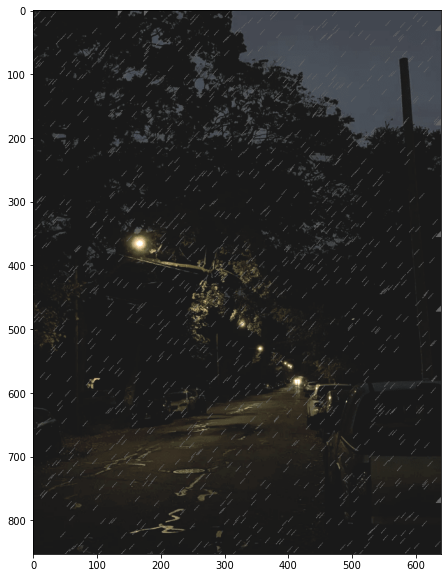

In [135]:
image_dir = './images'

img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB)
print(img.shape)
out = np.uint8(cp.asnumpy(rain_cupy(img ,1)))

plt.figure(figsize = (10,10))
plt.imshow(out)

(853, 640, 3)


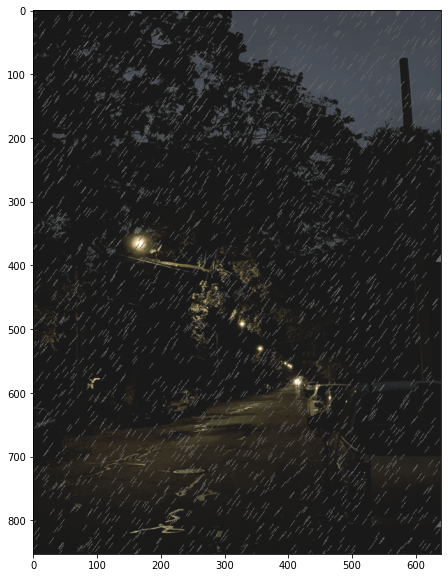

In [126]:
img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB)
print(img.shape)
out = np.uint8(cp.asnumpy(rain_cupy(img ,2)))

plt.figure(figsize = (10,10))
plt.imshow(out)

(853, 640, 3)


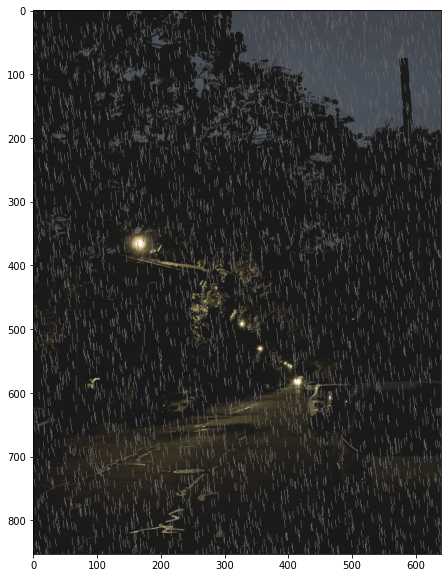

In [127]:
img = cv2.cvtColor(cv2.imread(image_dir + '/1.png'),cv2.COLOR_BGR2RGB)
print(img.shape)
out = np.uint8(cp.asnumpy(rain_cupy(img ,3)))

plt.figure(figsize = (10,10))
plt.imshow(out)